In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("./data/market/Rice.Nagpur.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index('Date', inplace=True)

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Price,1702.0,2114.762369,335.921081,1480.501442,1742.011008,2208.322325,2391.117104,2689.498558


<Axes: xlabel='Date'>

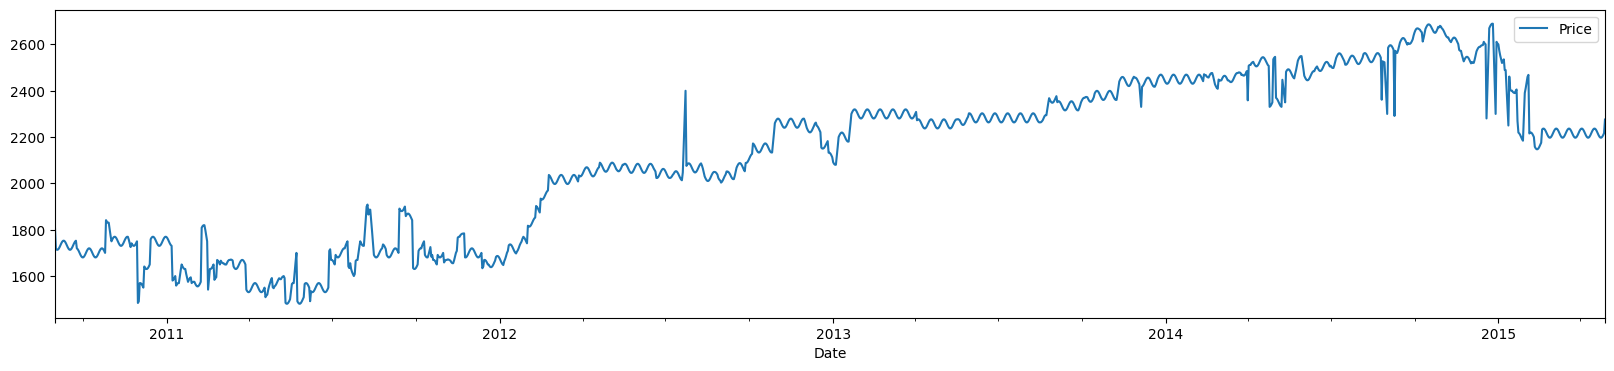

In [4]:
df.plot(figsize=(20, 4))

In [5]:
PREDICTION_DAYS = 28

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [25]:
sequence_length = 56

X, y = [], []

sequences = []

for i in range(len(df) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[(i + sequence_length)][0])

X = np.array(X)
y = np.array(y)

In [26]:
X.shape, y.shape

((1646, 56, 1), (1646,))

In [28]:
split = int(0.8 * len(X))

In [29]:
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

In [47]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential(
    [
        LSTM(units=64, return_sequences=True, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units=64, return_sequences=False),
        Dense(units=1),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 56, 64)            16896     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
history = model.fit(X_train, y_train, batch_size=28, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
47/47 [==============================] - 4s 42ms/step - loss: 0.0298 - val_loss: 0.0032
Epoch 2/50
47/47 [==============================] - 1s 31ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 3/50
47/47 [==============================] - 1s 31ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 4/50
47/47 [==============================] - 1s 32ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 5/50
47/47 [==============================] - 2s 34ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 6/50
47/47 [==============================] - 1s 32ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 7/50
47/47 [==============================] - 2s 33ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 8/50
47/47 [==============================] - 2s 33ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 9/50
47/47 [==============================] - 1s 31ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 10/50
47/47 [==============================] - 2s 32ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 11/

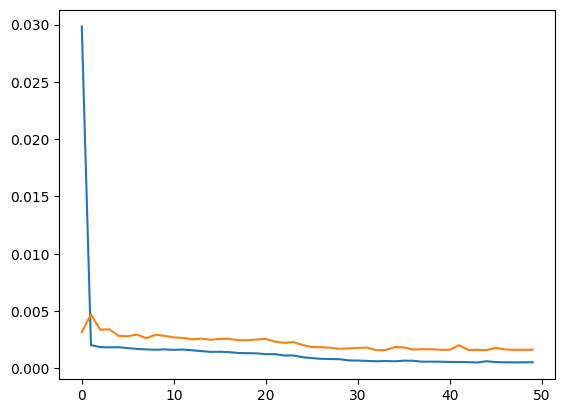

In [50]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [85]:
from joblib import dump, load

In [ ]:
# model = load("./out/forecast.LSTM.Nagpur.Rice.joblib")

In [72]:
x_test = scaled_data[-sequence_length:]
x_test = np.array([x_test])

In [76]:
predictions = model.predict(X)

52/52 [==============================] - 1s 14ms/step


In [77]:
predictions = scaler.inverse_transform(predictions).flatten()

In [78]:
predictions.shape

(1646,)

In [61]:
from datetime import timedelta

In [82]:
future_dates = [df.index[-1] + timedelta(days=i) for i in range(1, 29)]

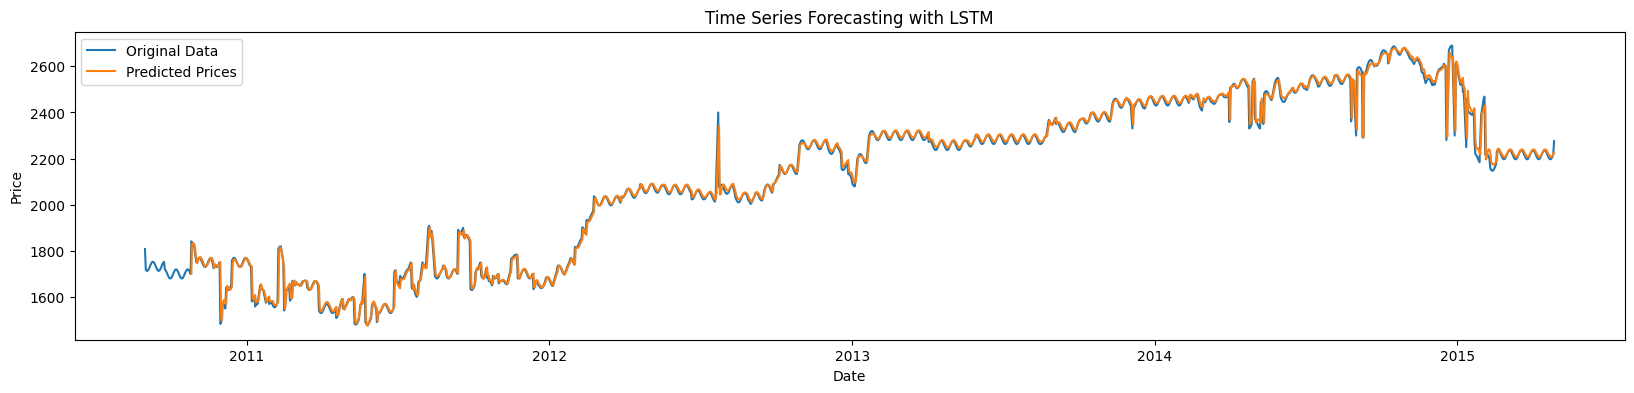

In [81]:
plt.figure(figsize=(20, 4))
plt.plot(df.index, df['Price'], label='Original Data')
plt.plot(df.index[sequence_length:], predictions, label='Predicted Prices')
plt.title('Time Series Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [87]:
dump(model, "./out/forecast.LSTM.Nagpur.Rice.joblib")

['./out/forecast.LSTM.Nagpur.Rice.joblib']

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

(
    mean_absolute_error(predictions, df["Price"][sequence_length:]),
    mean_squared_error(predictions, df["Price"][sequence_length:], squared=False),
)

(14.216949747335736, 32.28489938988908)